#Eye Tracker
It took me ~20min to run the whole on a P100

#####Logging

In [7]:
%%capture
!pip install ipython-autotime
%load_ext autotime

from IPython.display import HTML, display

def progress(value, max=100, message = ''):
    return HTML(f"""<progress
                    value="{value}"
                    max="{max}",
                    style="width: 50%"
                > {value}
                </progress> {message}""")

def message(value = ''):
    return HTML(f"{value}")

time: 2.83 s (started: 2021-04-08 18:18:04 +00:00)


In [8]:
!nvidia-smi -L

GPU 0: Tesla P100-PCIE-16GB (UUID: GPU-077b01c1-c876-80bb-c740-63d963a28b69)
time: 109 ms (started: 2021-04-08 18:18:07 +00:00)


##Preprocess data

###Download and decompress the data


In [9]:
from google_drive_downloader import GoogleDriveDownloader as gdd
import tarfile
import pathlib

!rm -rf sample_data
progressBar = display(progress(1, 4, 'Downloading'), display_id=True)
gdd.download_file_from_google_drive(file_id='1w5VN07QZygdtqAhmelHJskYD363TOOii',
                                    dest_path='./compressedData.tar')
progressBar.update(progress(2, 4, 'Decrompessing container'))
tar = tarfile.open('compressedData.tar')
tar.extractall('./compressedDataset')
tar.close()
progressBar.update(progress(3, 4, 'Decrompessing inner folders'))
!rm -rf compressedData.tar
for zipped_file in pathlib.Path("compressedDataset/").glob('*.tar.gz'):
    tar = tarfile.open(zipped_file, 'r:gz')
    tar.extractall('./completeDataset')
    tar.close()
progressBar.update(message(''))
!rm -rf compressedDataset

time: 2min 49s (started: 2021-04-08 18:18:07 +00:00)


### Format the data

In [ ]:
import json
from PIL import Image
import csv
import os

directory = 'completeDataset'
outDirectory = 'dataset'
if not os.path.exists(outDirectory):
          os.makedirs(outDirectory)
testCut = 0.1
count = 0
frameSize = (256,256)
with open(os.path.join(outDirectory,'train.csv'), mode='w') as trainDataframe, \
     open(os.path.join(outDirectory,'test.csv'), mode='w') as testDataframe:
  trainDfWriter = csv.writer(trainDataframe, delimiter=',')
  trainDfWriter.writerow(['image', 'leftX', 'leftY', 'rightX', 'rightY'])
  testDfWriter = csv.writer(testDataframe, delimiter=',')
  testDfWriter.writerow(['image', 'leftX', 'leftY', 'rightX', 'rightY'])
  decompressCount = 0
  dirCount = len(os.listdir(directory))
  progressBar = display(message(''), display_id=True)
  for dirName in os.listdir(directory):
    progressBar.update(progress(decompressCount,
                                dirCount,
                                f'{decompressCount}/{dirCount} decompressed directory'))
    infoPath = os.path.join(directory, dirName, 'info.json')
    if not os.path.exists(infoPath):
      continue
    with open(infoPath) as infofile:
      info = json.load(infofile)
    frameNumber = info['TotalFrames']
    testCutPoint = frameNumber * (1 - testCut)
    leftPath = os.path.join(directory, dirName, 'appleLeftEye.json')
    rightPath = os.path.join(directory, dirName, 'appleRightEye.json')
    facePath = os.path.join(directory, dirName, 'appleFace.json')
    with open(leftPath) as l, open(rightPath) as r, open(facePath) as f:
      leftEyes = json.load(l)
      rightEyes = json.load(r)
      faces = json.load(f)
    processedFrames = 0
    innerProgressBar = display(message(''), display_id=True)
    for i in range(frameNumber):
      innerProgressBar.update(progress(processedFrames,
                                       frameNumber,
                                       f'{processedFrames}/{frameNumber} processed frames'))
      if (leftEyes['IsValid'][i] and rightEyes['IsValid'][i]):
        framePath = os.path.join(directory, dirName, 'frames', '%05d.jpg' % i)
        saveDirPath = os.path.join(outDirectory, 'frames')
        if not os.path.exists(saveDirPath):
          os.makedirs(saveDirPath)
        savePath = os.path.join(saveDirPath, '%07d.jpg' % count)
        with Image.open(framePath) as frame:
          width, height = frame.size
          fresizesFrame = frame.resize(frameSize)
          fresizesFrame.save(savePath, 'JPEG')
        leftX = (faces['X'][i]+leftEyes['X'][i]+(leftEyes["W"][i]/2))/width
        leftY = (faces['Y'][i]+leftEyes['Y'][i]+(leftEyes["H"][i]/2))/height
        rightX = (faces['X'][i]+rightEyes['X'][i]+(rightEyes["W"][i]/2))/width
        rightY = (faces['Y'][i]+rightEyes['Y'][i]+(rightEyes["H"][i]/2))/height
        if i < testCutPoint:
          trainDfWriter.writerow([savePath, leftX, leftY, rightX, rightY])
        else:
          testDfWriter.writerow([savePath, leftX, leftY, rightX, rightY])
        count += 1
      processedFrames += 1
    innerProgressBar.update(message(''))
    decompressCount += 1
  !rm -rf {directory}
progressBar.update(message(f'loaded {count} frames'))

### Creating data generator

In [11]:
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator

trainDataframe = pd.read_csv('dataset/train.csv', delimiter=',')
testDataframe = pd.read_csv('dataset/test.csv', delimiter=',')

trainDatagen = ImageDataGenerator(rescale = 1./255,
                                  validation_split = 0.2)
testDatagen = ImageDataGenerator(rescale = 1./255)

print('Training')
trainGenerator = trainDatagen.flow_from_dataframe(
                                              dataframe = trainDataframe,
                                              x_col='image',
                                              y_col=['leftX', 'leftY', 'rightX', 'rightY'],
                                              class_mode = 'raw',
                                              target_size = frameSize,
                                              shuffle = True, 
                                              batch_size=32,
                                              subset = 'training')
print('Validation')
validGenerator = trainDatagen.flow_from_dataframe(
                                              dataframe = trainDataframe,
                                              x_col='image',
                                              y_col=['leftX', 'leftY', 'rightX', 'rightY'],
                                              class_mode = 'raw',
                                              target_size = frameSize,
                                              shuffle = True, 
                                              batch_size=32,
                                              subset = 'validation')
print('Testing')
testGenerator = testDatagen.flow_from_dataframe(
                                              dataframe = testDataframe,
                                              x_col='image',
                                              class_mode = None,
                                              shuffle = False,
                                              target_size = frameSize,
                                              batch_size = 1)

Data is linked by the table below
                        image     leftX     leftY    rightX    rightY
0  dataset/frames/0000000.jpg  0.717997  0.479674  0.393291  0.479674
1  dataset/frames/0000001.jpg  0.707850  0.494894  0.383144  0.494894
2  dataset/frames/0000002.jpg  0.677409  0.502504  0.372997  0.502504
3  dataset/frames/0000003.jpg  0.698391  0.478296  0.364588  0.471143
4  dataset/frames/0000004.jpg  0.679316  0.492602  0.374125  0.478296
Training
Found 22409 validated image filenames.
Validation
Found 5602 validated image filenames.
Testing
Found 3029 validated image filenames.
time: 2.27 s (started: 2021-04-08 18:28:00 +00:00)


## Creating the model

###Construct

In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, MaxPooling2D, Dense

model = Sequential([
    Conv2D(32, (5,5), input_shape = frameSize + (3,)),
    Conv2D(32, (5,5)),
    MaxPooling2D(5, 5),
    Conv2D(32, (3,3), activation='relu', kernel_initializer='he_normal'),
    Conv2D(32, (3,3), activation='relu', kernel_initializer='he_normal'),
    MaxPooling2D(5,5),
    Flatten(),
    Dense(128, activation='relu', kernel_initializer='he_normal'),
    Dense(64, activation='relu', kernel_initializer='he_normal'),
    Dense(4, activation='linear')
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 252, 252, 32)      2432      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 248, 248, 32)      25632     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 49, 49, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 47, 47, 32)        9248      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 45, 45, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 9, 9, 32)          0         
_________________________________________________________________
flatten (Flatten)            (None, 2592)              0

###Compile

In [13]:
from tensorflow.keras.callbacks import EarlyStopping

model.compile(optimizer = 'adam',
              loss = 'mse')
es = EarlyStopping(min_delta = 1e-4,
                        patience = 3,
                        verbose = 2,
                        restore_best_weights = True)

time: 15.5 ms (started: 2021-04-08 18:28:08 +00:00)


##Train

In [14]:
epochs = 10
history = model.fit(trainGenerator,  
                    verbose = 1,
                    validation_data = validGenerator,
                    callbacks = [es],
                    epochs = epochs)

Epoch 1/10
701/701 [==============================] - 95s 92ms/step - loss: 0.0240 - val_loss: 0.0255
Epoch 2/10
701/701 [==============================] - 62s 89ms/step - loss: 8.5511e-04 - val_loss: 0.0244
Epoch 3/10
701/701 [==============================] - 62s 88ms/step - loss: 4.7059e-04 - val_loss: 0.0185
Epoch 4/10
701/701 [==============================] - 62s 88ms/step - loss: 3.8309e-04 - val_loss: 0.0209
Epoch 5/10
701/701 [==============================] - 62s 89ms/step - loss: 3.0505e-04 - val_loss: 0.0142
Epoch 6/10
701/701 [==============================] - 62s 88ms/step - loss: 2.9974e-04 - val_loss: 0.0150
Epoch 7/10
701/701 [==============================] - 62s 88ms/step - loss: 2.3743e-04 - val_loss: 0.0132
Epoch 8/10
701/701 [==============================] - 62s 88ms/step - loss: 2.5579e-04 - val_loss: 0.0096
Epoch 9/10
701/701 [==============================] - 62s 88ms/step - loss: 2.0637e-04 - val_loss: 0.0122
Epoch 10/10
701/701 [=============================

##Evaluate

In [15]:
testGenerator.reset()
prediction = model.predict(testGenerator,
                     steps = len(testDataframe))
groundTruth = testDataframe[['leftX', 'leftY', 'rightX', 'rightY']].to_numpy()

time: 7.39 s (started: 2021-04-08 18:39:00 +00:00)


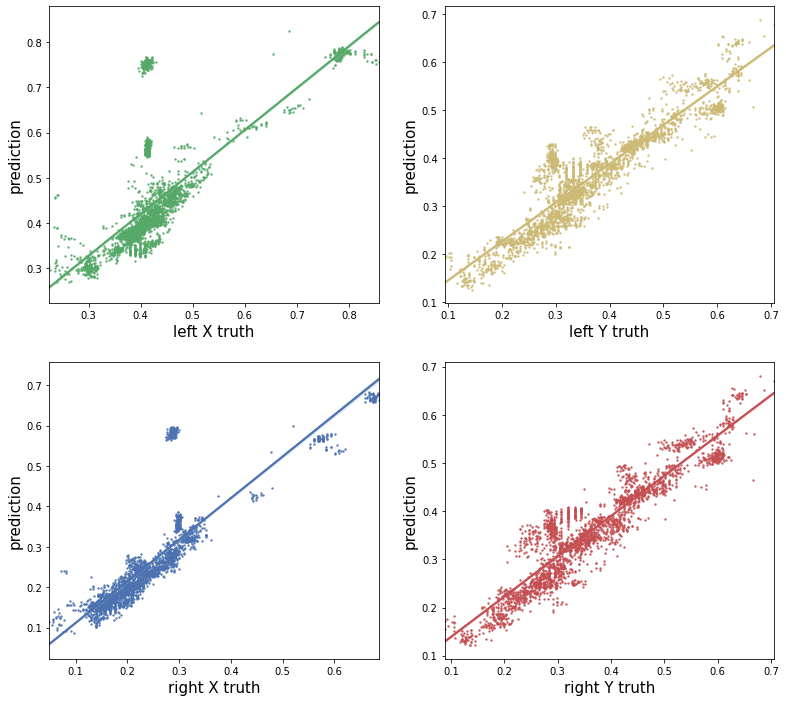

time: 1.97 s (started: 2021-04-08 18:39:07 +00:00)


In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, axs = plt.subplots(nrows = 2,
                        ncols = 2,
                        figsize=(13,12))
sns.set_theme(color_codes=True)
plots = []
plots.append(sns.regplot(x = groundTruth[:,0], y = prediction[:,0], ax = axs[0,0], color = 'g', scatter_kws = {'s':2}))
plots.append(sns.regplot(x = groundTruth[:,1], y = prediction[:,1], ax = axs[0,1], color = 'y', scatter_kws = {'s':2}))
plots.append(sns.regplot(x = groundTruth[:,2], y = prediction[:,2], ax = axs[1,0], color = 'b', scatter_kws = {'s':2}))
plots.append(sns.regplot(x = groundTruth[:,3], y = prediction[:,3], ax = axs[1,1], color = 'r', scatter_kws = {'s':2}))
labels = ['left X truth', 'left Y truth', 'right X truth', 'right Y truth']
for i, plot in enumerate(plots):
  plot.set_xlabel(labels[i], fontsize = 15)
  plot.set_ylabel('prediction', fontsize = 15)
  plot.tick_params(labelsize = 10)